In [105]:
import tensorflow as tf
import tensorflow.keras as keras 

In [106]:
from tensorflow.keras.preprocessing import image

DATA_DIR = "data/small-set/"
KNOWN_DATA_DIR = DATA_DIR + "known-data/"
QUERY_DATA_DIR = DATA_DIR + "query-data/"

# load data within given "directory"
def load_data(directory):
    data = {}
    _, dirs, __ = next(os.walk(directory))
    for d in dirs:
        _, __, files = next(os.walk(directory + d))
        data[d] = []
        for file_name in files:
            file_path = directory + d + "/" + file_name 
            data[d].append(image.load_img(file_path, target_size=(224, 224)))
    return data

known = load_data(KNOWN_DATA_DIR)
query = load_data(QUERY_DATA_DIR)

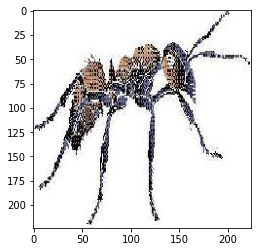

In [107]:
import matplotlib.pyplot as plt 
plt.imshow(known["ant"][0])

In [117]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

# each feature 
def extract_feature(model, src_image):
    img_input = image.img_to_array(src_image)
    img_input = np.expand_dims(img_input, axis=0) # == [x]
    img_input = preprocess_input(img_input)
    return model.predict(img_input)[0].flatten()

model = VGG16(weights="model/vgg16", include_top=False)

features = {}
# make get features:
for kind in known:
    features[kind] = alist = []
    for i in range(len(known[kind])):
        alist.append(extract_feature(model, known[kind][i]))

In [109]:
from sklearn.metrics.pairwise import cosine_similarity 
import numpy as np
src_image = image.load_img("data/small-set/query-data/ant/image_0035.jpg", target_size=(224, 224))
img_feature = extract_feature(model, src_image)
# for kind in known:
# cosines = cosine_similarity(features["ant"], [img_input])
print(cosine_similarity(features["ant"], [img_feature])[0])
print(cosine_similarity(features["cellphone"], [img_feature])[0])
print(cosine_similarity(features["headphone"], [img_feature])[0])
print(cosine_similarity(features["windsor_chair"], [img_feature])[0])

[0.1569166]
[0.10805108]
[0.06761897]
[0.13442044]


Searching done in 0.017063140869140625 second. Iterated over 147 sample(s). Rendering...


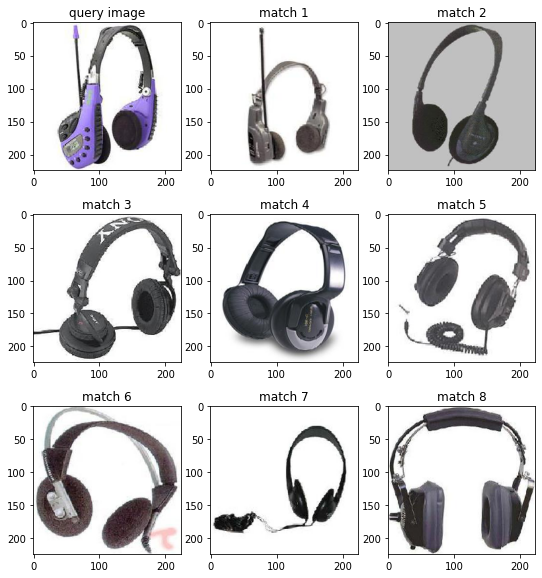

In [110]:
from sklearn.metrics.pairwise import cosine_similarity 
import numpy as np
import time

def search(query_image_path):
    # Draw images:
    src_image = image.load_img(query_image_path, target_size=(224, 224))
    img_feature = extract_feature(model, src_image)

    marker = time.time()
    similarities = []
    for kind, feature_matrix in features.items():
        index = 0
        for cosine in cosine_similarity(feature_matrix, [img_feature]):
            similarities.append((cosine[0], (kind, index)))
            index += 1
    similarities.sort(reverse=True)
    print("Searching done in", time.time()-marker, "second. Iterated over", len(similarities), "sample(s). Rendering...")

    import matplotlib.pyplot as plt 
    fig=plt.figure(figsize=(9, 10))

    top_k = 8
    # subplot_index = 0
    for i in range(top_k+1):
        fig.add_subplot(3, 3, i+1)
        if i == 0:
            plt.title("query image")
            plt.imshow(src_image)
            continue

        plt.title("match %d" % i)
        known_element = similarities[i-1]
        plt.imshow(known[known_element[1][0]][known_element[1][1]])
query_image_path = "data/small-set/query-data/headphone/image_0035.jpg"
search(query_image_path)

Searching done in 0.017822980880737305 second. Iterated over 147 sample(s). Rendering...


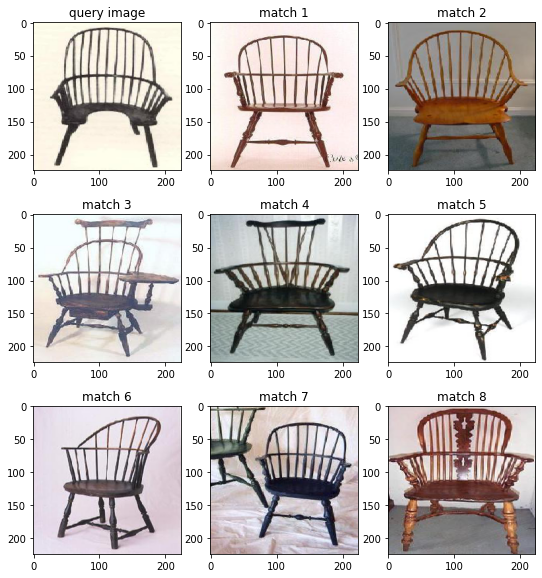

In [111]:
query_image_path = "data/small-set/query-data/windsor_chair/image_0050.jpg"
search(query_image_path)

# Use spotify/annoy for indexing


In [104]:
!pip3 install annoy

In [133]:
from annoy import AnnoyIndex
import random

indexer = AnnoyIndex(25088, "angular")
images = []
for kind in known:
    images.extend(known[kind])

feature_array = []
for kind in known:
    feature_array.extend(features[kind])

for i in range(len(feature_array)):
    indexer.add_item(i, feature_array[i])
indexer.build(6) # 10 trees

True

True

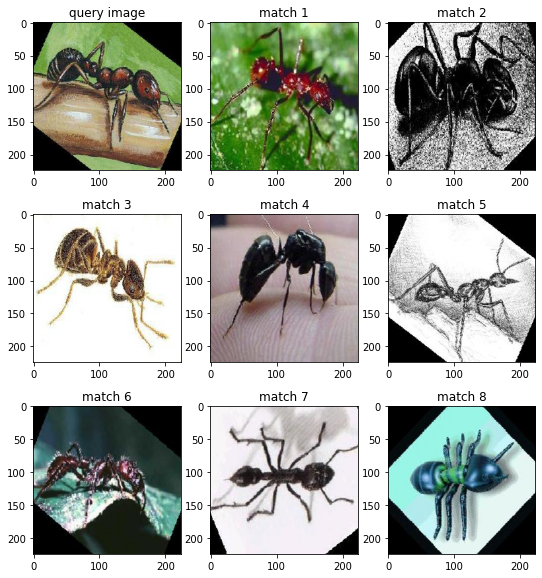

In [137]:
import matplotlib.pyplot as plt

query_image_path = "data/small-set/query-data/ant/image_0035.jpg"
src_image = image.load_img(query_image_path, target_size=(224, 224))
img_feature = extract_feature(model, src_image)

hits = indexer.get_nns_by_vector(img_feature, 8, search_k=3, include_distances=False)

def show_hits(images, src_image, hits):
    fig=plt.figure(figsize=(9, 10))

    top_k = 8
    # subplot_index = 0
    for i in range(top_k+1):
        fig.add_subplot(3, 3, i+1)
        if i == 0:
            plt.title("query image")
            plt.imshow(src_image)
            continue

        plt.title("match %d" % i)
        plt.imshow(images[hits[i-1]])
show_hits(images, src_image, hits)
indexer.save('test.ann')

Hits: [29, 28, 3, 26, 5, 33, 0, 22, 21, 31, 19, 7, 13, 6, 1, 49, 16, 14, 24, 43, 10, 32, 4, 128, 23, 25, 17, 11, 9, 121, 8, 34, 111, 12, 143, 20, 112, 145, 75, 113, 48, 39, 136, 104, 18, 93, 106, 76, 102, 77, 103, 52, 139, 69, 40, 36, 114, 51, 64, 2, 140, 98, 38, 68, 115, 141, 55, 122, 37, 96, 142, 30, 59, 94, 127, 67, 82, 95, 135, 90, 126, 71, 81, 27, 78, 108, 63, 120, 107, 54, 110, 50, 125, 58, 83, 100, 41, 74, 132, 57]


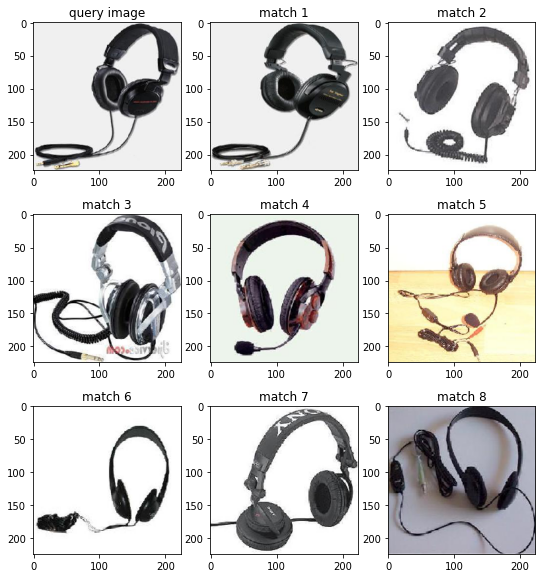

In [144]:
# Try reload model from file:
from annoy import AnnoyIndex
import random

query_image_path = "data/small-set/query-data/headphone/image_0042.jpg"
src_image = image.load_img(query_image_path, target_size=(224, 224))
img_feature = extract_feature(model, src_image)

indexer = AnnoyIndex(25088, "angular")
indexer.load("test.ann")
hits = indexer.get_nns_by_vector(img_feature, 100, search_k=-1, include_distances=False)
print("Hits:", hits)
show_hits(images, src_image, hits[:8])
